In [2]:
import torch
import numpy as np
import torchvision
import crypten
import sklearn
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm

In [54]:
!mkdir one_hot_target/data_samples_sub50x
!mkdir one_hot_target/data_samples_sub50x/2
!mkdir one_hot_target/data_samples_sub50x/2/train
!mkdir one_hot_target/data_samples_sub50x/2/val

mkdir: cannot create directory ‘one_hot_target/data_samples_sub50x’: File exists
mkdir: cannot create directory ‘one_hot_target/data_samples_sub50x/2’: File exists
mkdir: cannot create directory ‘one_hot_target/data_samples_sub50x/2/train’: File exists
mkdir: cannot create directory ‘one_hot_target/data_samples_sub50x/2/val’: File exists


In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

subsample_size = 0.02

mnist_train = torchvision.datasets.MNIST(root = '../../../datasets/mnist', 
                                         download = True, 
                                         train = True, 
                                         transform = transform)
mnist_val = torchvision.datasets.MNIST(root = '../../../datasets/mnist', 
                                       download = True, 
                                       train = False, 
                                       transform = transform)

subsample_train_ids = np.random.randint(0, len(mnist_train), int(len(mnist_train)*subsample_size))
subsample_val_ids = np.random.randint(0, len(mnist_val), int(len(mnist_val)*subsample_size))

mnist_train = torch.utils.data.Subset(mnist_train, subsample_train_ids)
mnist_val = torch.utils.data.Subset(mnist_val, subsample_val_ids)

In [56]:
batch_size = 128
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=2)

In [57]:
def extract(dataloader, num_classes):
    
    one_hot_vecs = torch.nn.functional.one_hot(torch.arange(num_classes), num_classes)
    
    X_all = torch.tensor([])
    y_all = torch.tensor([])
    
    for i, data in enumerate(dataloader, 0):
        X, y = data
        X_all = torch.cat((X_all, X), dim = 0)
        for y_val  in y:
            y_all = torch.cat((y_all, one_hot_vecs[y_val].unsqueeze(0)), dim = 0)
            
    return X_all, y_all

In [58]:
mnist_train_data, mnist_train_targets = extract(mnist_train_dataloader, num_classes = 10)
mnist_val_data, mnist_val_targets = extract(mnist_val_dataloader, num_classes = 10)

(<matplotlib.image.AxesImage at 0x7f5e340c63d0>,
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))

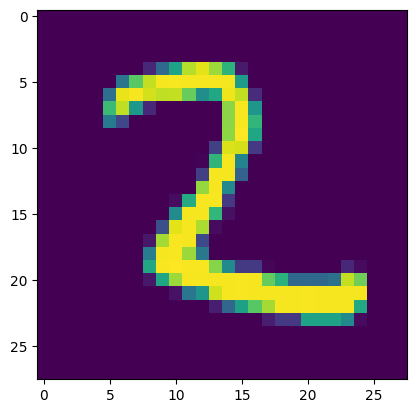

In [59]:
plt.imshow(mnist_val_data[2][0]), mnist_val_targets[2]

In [60]:
mnist_train_targets_shuffled, mnist_train_data_shuffled = sklearn.utils.shuffle(mnist_train_targets, 
                                                                                mnist_train_data)
mnist_val_targets_shuffled, mnist_val_data_shuffled = sklearn.utils.shuffle(mnist_val_targets, 
                                                                            mnist_val_data)
num_parties = 2

mnist_train_targets_shuffled_split = np.split(mnist_train_targets_shuffled, num_parties)
mnist_train_data_shuffled_split = np.split(mnist_train_data_shuffled, num_parties)

mnist_val_targets_shuffled_split = np.split(mnist_val_targets_shuffled, num_parties)
mnist_val_data_shuffled_split = np.split(mnist_val_data_shuffled, num_parties)

In [61]:
for party in range(num_parties):
    torch.save(mnist_train_targets_shuffled_split[party], f"./one_hot_target/data_samples_sub{int(1/subsample_size)}x/{num_parties}/train/targets_{party}.pth")
    torch.save(mnist_train_data_shuffled_split[party], f"./one_hot_target/data_samples_sub{int(1/subsample_size)}x/{num_parties}/train/data_{party}.pth")
    torch.save(mnist_val_targets_shuffled_split[party], f"./one_hot_target/data_samples_sub{int(1/subsample_size)}x/{num_parties}/val/targets_{party}.pth")
    torch.save(mnist_val_data_shuffled_split[party], f"./one_hot_target/data_samples_sub{int(1/subsample_size)}x/{num_parties}/val/data_{party}.pth")

In [57]:
crypten.init()
ALICE = 1
BOB = 0

/future/u/alexder/anaconda3/envs/cs356v2/lib/python3.9/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [50]:
train_indices = np.arange(len(mnist_train))
val_indices = np.arange(len(mnist_val))

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

alice_train_indices = train_indices[:int(len(train_indices)/2)]
bob_train_indices = train_indices[int(len(train_indices)/2):]

alice_val_indices = val_indices[:int(len(val_indices)/2)]
bob_val_indices = val_indices[int(len(val_indices)/2):]

alice_train_dataset = torch.utils.data.Subset(mnist_train, alice_train_indices)
bob_train_dataset = torch.utils.data.Subset(mnist_train, bob_train_indices)

alice_val_dataset = torch.utils.data.Subset(mnist_val, alice_val_indices)
bob_val_dataset = torch.utils.data.Subset(mnist_val, bob_val_indices)

In [61]:
torch.save(alice_train_dataset, './data_samples/alice_train_dataset.pth')
torch.save(bob_val_dataset, './data_samples/bob_val_dataset.pth')
torch.save(alice_train_dataset, './data_samples/alice_train_dataset.pth')
torch.save(bob_val_dataset, './data_samples/bob_val_dataset.pth')

In [51]:
alice_dataloader_train = torch.utils.data.DataLoader(dataset = alice_train_dataset, batch_size = batch_size, shuffle = True)
bob_dataloader_train = torch.utils.data.DataLoader(dataset = bob_train_dataset, batch_size = batch_size, shuffle = True)

alice_dataloader_val = torch.utils.data.DataLoader(dataset = alice_val_dataset, batch_size = batch_size, shuffle = True)
bob_dataloader_val = torch.utils.data.DataLoader(dataset = bob_val_dataset, batch_size = batch_size, shuffle = True)

In [58]:
#First Step. Initialize an encypted ResNet model

resnet18_plaintext = torchvision.models.resnet18()
dummy_input = torch.empty((64, 3, 7, 7))

model_enc = crypten.nn.from_pytorch(resnet18_plaintext, dummy_input)
model_enc.encrypt()

Graph encrypted module

In [ ]:
x_alice_enc = crypten.load_from_party('/data_samples/alice_train_dataset.pth', src=ALICE)
x_alice_enc = crypten.load_from_party('/data_samples/alice_train_dataset.pth', src=ALICE)
x_bob_enc = crypten.load_from_party('/tmp/bob_train.pth', src=BOB)

crypten.print(x_alice_enc.size())
crypten.print(x_bob_enc.size())

In [3]:
model_enc.train()
loss = crypten.nn.MSELoss() 


learning_rate = 0.001
num_epochs = 2

# Train the model: SGD on encrypted data
for i in range(num_epochs):

    # forward pass
    output = model_enc(x_train)
    loss_value = loss(output, y_train)
    
    # set gradients to zero
    model.zero_grad()

    # perform backward pass
    loss_value.backward()

    # update parameters
    model.update_parameters(learning_rate) 
    
    # examine the loss after each epoch
    print("Epoch: {0:d} Loss: {1:.4f}".format(i, loss_value.get_plain_text()))

playground.ipynb  tutorials
